# Recommend System
-------------------

# Import Libraries

In [22]:
import math
import random
import numpy as np
import pandas as pd

from keras.models import Model
from keras import backend as bd
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.engine.topology import Layer
from keras.layers.core import Dense, Lambda
from keras.layers import Input, Embedding, Flatten

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt

# Preprocessing

In [23]:
POS = 4.0
NEG = 3.0

def get_pos(df, anchor):
    ps = df.loc[anchor] >= POS
    return ps[ps].index.values

def get_neg(df, anchor):
    ps = df.loc[anchor] <= NEG
    return ps[ps].index.values

In [24]:
def process_features(df, con_features, cat_features):
    X_cat = []
    X_con = []

    for column in con_features:
        X = np.array(df[column])
        X_con.append(X)

    for column in cat_features:
        X = np.asarray(df[column].tolist())
        X_line = pd.factorize(X)[0]
        X_cat.append(np.asarray(X_line))

    try: X_con = np.column_stack(X_con)
    except: pass

    try: X_cat = np.column_stack(X_cat)
    except: pass

    if(len(cat_features) > 0) and (len(con_features) > 0):
        X = np.concatenate((X_con, X_cat), axis=1)
    elif len(cat_features) == 0:
        X = X_con
    elif len(con_features) == 0:
        X = X_cat
    else:
        X = None
    
    return X

# Load Data

In [25]:
df_ratings = pd.read_csv('data/ratings.csv')

df_items = pd.read_csv('data/items.csv')
n_items = df_items.movie_id.nunique()

df_users = pd.read_csv('data/users.csv')
n_users = df_users.user_id.nunique()

df_matrix = df_ratings.pivot(index='user_id', columns='movie_id', values='rating')

In [26]:
user_con_features = ['age']
user_cat_features = ['sex', 'occupation']

item_features = ['action', 'adventure', 'animation', 'children', 'comedy',
                'crime','documentary', 'drama', 'fantasy','film_noir','horror',
                'musical','mystery','romance','sci_fi','thriller','war','western']

In [27]:
X_user = process_features(df_users, user_con_features, user_cat_features)
X_item = process_features(df_items, item_features, [])

# Model Building

## Defien Layers

In [28]:
class TripletLossLayer(Layer):
    def __init__(self, **kwargs):
        super(TripletLossLayer, self).__init__(**kwargs)

    def bpr_triple_loss(self, inputs):
        anchor, positive, negative = inputs
        p_score = bd.dot(anchor, bd.transpose(positive))
        n_score = bd.dot(anchor, bd.transpose(negative))
        return bd.log(1.0 - bd.sigmoid(p_score - n_score))
    
    def call(self, inputs):
        loss = self.bpr_triple_loss(inputs)
        self.add_loss(loss)
        return loss

class ScoreLayer(Layer):
    def __init__(self, **kwargs):
        super(ScoreLayer, self).__init__(**kwargs)

    def rec_similarity(self, inputs):
        anchor, item = inputs
        score = bd.dot(anchor, bd.transpose(item))
        return score
    
    def call(self, inputs):
        pred = self.rec_similarity(inputs)
        return pred

## Defien Model

In [29]:
def build_model(n_users, n_items, n_factors = 30):
    n_user_features = 3
    n_item_features = 18

    user_input = Input((n_user_features,), name='user_input')
    pos_item_input = Input((n_item_features,), name='pos_item_input')
    neg_item_input = Input((n_item_features,), name='neg_item_input')

    inputs = [user_input, pos_item_input, neg_item_input]

    user_embedding = Embedding(n_users, n_factors, input_length=n_user_features, name='user_embedding')
    item_embedding = Embedding(n_items, n_factors, input_length=n_item_features, name='item_embedding')

    vec_con_64 = Dense(64, name='dense_vec_64', activation='relu')
    vec_con_32 = Dense(32, name='dense_vec_32', activation='relu')

    vec_conv = Dense(n_factors, name='dense_vec', activation='softmax')

    user_flatten = Flatten(name='flatten_user_embedding')(user_embedding(user_input))
    user_dense = Dense(n_factors, name='dense_user', activation='softmax')(user_flatten)

    pos_flatten = Flatten(name='flatten_pos_embedding')(item_embedding(pos_item_input))
    pos_dense = vec_con_32(pos_flatten)
    pos_dense = vec_conv(pos_dense)

    neg_flatten = Flatten(name='flatten_neg_embedding')(item_embedding(neg_item_input))
    neg_dense = vec_con_32(neg_flatten)
    neg_dense = vec_conv(neg_dense)

    pos_rec_score = ScoreLayer(name='pos_recomendation_score')([user_dense, pos_dense])
    neg_rec_score = ScoreLayer(name='neg_recomendation_score')([user_dense, neg_dense])

    loss_layer = TripletLossLayer(name='triplet_loss_layer')([user_dense, pos_dense, neg_dense])

    train_model = Model(inputs, loss_layer, name='training_model')
    predic_model = Model(inputs[:-1], pos_rec_score, name='inference_model')

    train_model.compile(loss=None, optimizer=Adam(lr=0.001))

    return train_model, predic_model


In [30]:
train_model, predic_model = build_model(n_users, n_items)

# Training Phase

## Building Batch

In [31]:
def cosine_dist(x, y, eps=1e-6):
    return 1 - np.dor(x, y.T)/(np.linalg.norm(x)*np.linalg.norm(y) + eps)

In [32]:
def split_random(size, X_user, X_item, df):
    n_user_features = X_user.shape[1]
    n_item_features = X_item.shape[1]

    user_list = list(df.index.values)
    results = []

    for i in range(size):
        anchor_id = random.choice(user_list)

        pos_movie_id = get_pos(df, anchor_id)

        try: positive_id = random.choice(pos_movie_id)
        except: positive_id = 0

        results.append([anchor_id, positive_id])
    
    return pd.DataFrame(data=results, columns=["user_id", "movie_id"])

In [33]:
def get_triple_hard(size, X_user, X_item, df):
    n_user_features = X_user.shape[1]
    n_item_features = X_item.shape[1]

    user_list = list(df.index.values)
    results = [
        np.zeros((size, n_user_features)),
        np.zeros((size, n_item_features)),
        np.zeros((size, n_item_features))
    ]
    user_ids = []
    pos_ids = []
    neg_ids = []

    for i in range(size):
        anchor_id = random.choice(user_list)
        user_ids.append(anchor_id)

        pos_movie_id = get_pos(df, anchor_id)
        neg_movie_id = get_neg(df, anchor_id)

        try: positive_id = random.choice(pos_movie_id)
        except: positive_id = 0
        pos_ids.append(positive_id)

        try:
            neg_min = np.argmin([(cosine_dist(X_item[positive_id - 1], X_item[k-1])) for k in neg_movie_id]) 
            negative_id = neg_movie_id[neg_min]
        except:
            try:negative_id = random.choice(neg_movie_id)
            except:negative_id = 0
        neg_ids.append(negative_id)

        results[0][i,:] = X_user[anchor_id - 1][:]
        
        if positive_id == 0:
            results[1][i,:] = np.zeros((n_item_features))
        else:
            results[1][i,:] = X_item[positive_id - 1][:]
        
        if negative_id == 0:
            results[2][i,:] = np.zeros((n_item_features))
        else:
            results[2][i,:] = X_item[negative_id - 1][:]
    
    return results

## Traning over batches

In [34]:
BATCH_SIZE = 10
EVALUATE_EVERY = 100
NUMBER_VALIDATE = 1000
NUMBER_ITERATIONS = 2000

In [35]:
import time

try:
    train_model.load_weights('resources/hybrid/train_model.h5')
    predic_model.load_weights('resources/hybrid/predic_model.h5')
    
except OSError:
    log_file = open('resources/hybrid/log_training', 'w')

    log_file.write('Start training process!')
    log_file.write('---------------------------------')

    time_start = time.time()
    n_iterations = 0
    for i in range(1, NUMBER_ITERATIONS + 1):
        results = get_triple_hard(BATCH_SIZE, X_user, X_item, df_matrix)
        loss = train_model.train_on_batch([results[0], results[1], results[2]], None)
        n_iterations += 1
        if i % EVALUATE_EVERY == 0:
            log_file.write('\n--------------\n')
            log_file.write('[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}'.format(i, (time.time() - time_start)/60.0, loss, n_iterations))
        if i % (EVALUATE_EVERY * 10) == 0:    
            print(f'[{i}] ...')
    train_model.save_weights('resources/hybrid/train_model.h5')
    predic_model.save_weights('resources/hybrid/predic_model.h5')


In [36]:
try:
    train = pd.read_csv('resources/hybrid/training.csv')
except FileNotFoundError:
    n_train = int(df_ratings.shape[0] * 0.8)
    train = split_random(n_train, X_user, X_items, df_matrix)
    train.to_csv('resources/hybrid/training.csv')

# Evaluation

In [37]:
predic_model.predict([X_user[:1], X_item[7:8]])

array([[1.5799806e-05]], dtype=float32)

In [38]:
predic_model.predict([X_user[:1], X_item[1:]])

array([[3.0051595e-10]], dtype=float32)

In [39]:
def compute_probs(model, X_user, X_item, thrs=0.5):
    m = X_user.shape[0]
    nbevaluation = int(m**2)
    X = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))

    k = 0
    for i in range(1, m):
        for j in range(1, m):
            X[k] = float(model.predict([X_user[i-1:i], X_item[j-1:j]]))
            if X[k] > thrs: y[k] = 1
            else: y[k] = 0
            k += 1
    return X, y

def compute_metrics(X, y):
    auc = roc_auc_score(y, X)
    fpr, tpr, thresholds = roc_curve(y, X)
    return fpr, tpr, thresholds, auc

def find_nearest(array, value):
    idx = np.searchsorted(array, value, side='left')
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math .fabs(value - array[idx])):
        return array[idx-1], idx-1
    else:
        return array[idx], idx

def draw_roc(fpr, tpr, threshold):
    targetfpr=1e-3
    _, idx = find_nearest(fpr, targetfpr)
    threshold = threshold[idx]
    recall = tpr[idx]

    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC:{0:.3f}\nSensitivity : {2:.1f} @FPR={1:.0e}\nThreshold={3}'.format(auc, targetfpr, recall, abs(threshold)))
    plt.show()

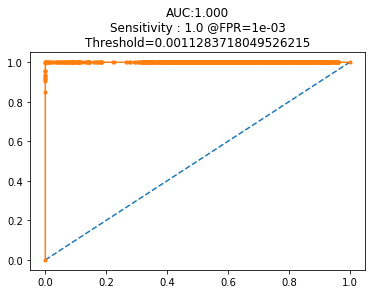

In [40]:
X, y = compute_probs(predic_model, X_user[:100], X_item[:100], thrs=0.02)
fpr, tpr, threshold, auc = compute_metrics(X, y)
draw_roc(fpr, tpr, threshold)

In [41]:
def get_embedding(model, name):
    embedding = model.get_layer(name = name).get_weights()[0]
    return embedding

In [42]:
item_embedding = get_embedding(predic_model, 'item_embedding')
user_embedding = get_embedding(predic_model, 'user_embedding')

In [56]:
def get_predictions(model, df, X_user, X_item):
    user_item = []

    for index in range(len(df)):
        i = df.user_id[index]
        j = df.movie_id[index]
        
        try:user_item.append([i, j, float(model.predict([X_user[i-1:i], X_item[j-1:j]]))])
        except: pass
    
    user_item = pd.DataFrame(data=user_item, columns=['user_id', 'movie_id','predict'])
    return user_item

In [60]:
try:
    predictions = pd.read_csv('resources/hybrid/predictions.csv')
except FileNotFoundError:
    predictions = get_predictions(predic_model, train, X_user, X_item)
    predictions.to_csv('resources/hybrid/predictions.csv')

In [84]:
def get_top_k_items(df, col_user, col_rating, k=10):
    top_k_items = (
        df.groupby(col_user, as_index=True)
        .apply(lambda x: x.nlargest(k, col_rating))
        .reset_index(drop=True)
    )
    top_k_items["rank"] = top_k_items.groupby(col_user, sort=True).cumcount() + 1
    return top_k_items

def recommend_topk(predictions, train, k=5):
    predictions.fillna(0, inplace=True)
    recommend_topk_df = get_top_k_items(predictions, 'user_id', 'predict', k=5)
    return recommend_topk_df


In [90]:
try:
    ranking_top = pd.read_csv('resources/hybrid/ranking_top.csv')
except FileNotFoundError:
    ranking_top = recommend_topk(predictions, train)
    ranking_top.to_csv('resources/hybrid/ranking_top.csv')

In [91]:
def get_hit_df(rating_true, rating_pred, k):
    common_users = set(rating_true["user_id"]).intersection(set(rating_pred["user_id"]))
    rating_true_common = rating_true[rating_true["user_id"].isin(common_users)]
    rating_pred_common = rating_pred[rating_pred["user_id"].isin(common_users)]
    n_users = len(common_users)
    df_hit = get_top_k_items(rating_pred_common, "user_id", "predict", k)
    df_hit = pd.merge(df_hit, rating_true_common, on=["user_id", "movie_id"])[
        ["user_id", "movie_id", "rank"]
    ]
    df_hit_count = pd.merge(
        df_hit.groupby("user_id", as_index=False)["user_id"].agg({"hit": "count"}),
        rating_true_common.groupby("user_id", as_index=False)["user_id"].agg(
            {"actual": "count"}
        ),
        on="user_id",
    )
    return df_hit, df_hit_count, n_users

def precision_at_k(rating_true, rating_pred, k):
    df_hit, df_hit_count, n_users = get_hit_df(rating_true, rating_pred, k)
    if df_hit.shape[0] == 0:
        return 0.0
    return (df_hit_count["hit"] / k).sum() / n_users

def recall_at_k(rating_true, rating_pred, k):
    df_hit, df_hit_count, n_users = get_hit_df(rating_true, rating_pred, k)
    if df_hit.shape[0] == 0:
        return 0.0
    return (df_hit_count["hit"] / df_hit_count["actual"]).sum() / n_users

def ndcg_at_k(rating_true, rating_pred, k):
    df_hit, df_hit_count, n_users = get_hit_df(rating_true, rating_pred, k)
    if df_hit.shape[0] == 0:
        return 0.0
    df_dcg = df_hit.copy()
    df_dcg["dcg"] = 1 / np.log1p(df_dcg["rank"])
    df_dcg = df_dcg.groupby("user_id", as_index=False, sort=False).agg({"dcg": "sum"})
    df_ndcg = pd.merge(df_dcg, df_hit_count, on=["user_id"])
    df_ndcg["idcg"] = df_ndcg["actual"].apply(
        lambda x: sum(1 / np.log1p(range(1, min(x, k) + 1)))
    )
    return (df_ndcg["dcg"] / df_ndcg["idcg"]).sum() / n_users

In [93]:
eval_precision = precision_at_k(train[:100], ranking_top, k=10)
eval_recall = recall_at_k(train[:100], ranking_top, k=10)
eval_ndcg = ndcg_at_k(train[:100], ranking_top, k=10)

print(
    f' NDCG_K:\t{eval_ndcg}\n', 
    f'Recall_K:\t{eval_recall}\n'
    f' Precision_K:\t{eval_precision}\n', 
)

 NDCG_K:	0.5857475960581475
 Recall_K:	0.7043010752688172
 Precision_K:	0.07204301075268817



# Get Similar Items

In [94]:
def get_similar(embedding, k):
    model_similar_items = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(embedding)
    distance, indece = model_similar_items.kneighbors(embedding)
    return distance, indece

In [95]:
item_distance, item_similar_indice = get_similar(item_embedding, 5)
item_similar_indice

array([[   0, 1124,  606,  825, 1408],
       [   1,    3, 1141,  942, 1251],
       [   2,  934,  751,  170,  182],
       ...,
       [1679,  743, 1486,  686,  443],
       [1680,  203,  845,  840, 1615],
       [1681,  274,  172,  693,  171]], dtype=int64)

In [98]:
def print_similar(item_index, item_similar_indices, df):
    encode_df = df.copy()
    item_encode = LabelEncoder()
    item_encode.fit(encode_df.movie_id.values)
        
    s = item_similar_indices[item_index]
    movie_ids = item_encode.inverse_transform(s)

    print(movie_ids)

print_similar(0, item_similar_indice, df_items)

[   1 1125  607  826 1409]
